D213: Advanced Data Analytics - Performance Assessment 1

Student Information

Student Name: Jackson Goyette

ID Number: 011028154

Date: 2024-11-26

A1: Can we use the time series provided to build an ARIMA model to accurately predict future revenue? Futhermore, with this model, can we create a business plan that fosters the predicted growth or "triages" a potential downturn in revenue?

A2: The goal of this analysis will be to use an ARIMA model to forecast the revenue from the quarter following our provided data. Using the projection from the model, we will determine if action needs to be taken to assure revenue does not fall.

B: The largest assumption of time series (and of data analysis in general) is that past trends can give us insight into future ones. Time series in particular do this by assuming stationarity. Stationarity is the measure of the consistency of mean and variance over time. This can be tested multiple ways, and in each of the tests, the null hypothesis is that the time series is non-stationary.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt

C2: 
We start by importing the data and checking for any null values in our dataframe.

In [2]:
# Code in part adapted from Dr. Festus Elleh and Dr. William Sewell's D213 Webinars

time_df = pd.read_csv("teleco_time_series .csv")

print(time_df.isnull().any())
print(time_df.shape)

Day        False
Revenue    False
dtype: bool
(731, 2)


C2 cont: 
Both columns return "False," so all of the dates have associated Revenue values. Next, knowing our data has no gaps, we assign a date to each value in the "Day" column. With 731 entries, we know that one of our years has to be a leap year, so I went with the most recent leap year and the following year (2020-2021).

In [3]:
time_df["Day"] = pd.date_range(start = datetime(2020, 1, 1), periods = time_df.shape[0], freq = "24h")

time_df.set_index("Day", inplace = True)

print(time_df.head)

<bound method NDFrame.head of               Revenue
Day                  
2020-01-01   0.000000
2020-01-02   0.000793
2020-01-03   0.825542
2020-01-04   0.320332
2020-01-05   1.082554
...               ...
2021-12-27  16.931559
2021-12-28  17.490666
2021-12-29  16.803638
2021-12-30  16.194813
2021-12-31  16.620798

[731 rows x 1 columns]>


C1: 
The following code shows the process to graph the time series.

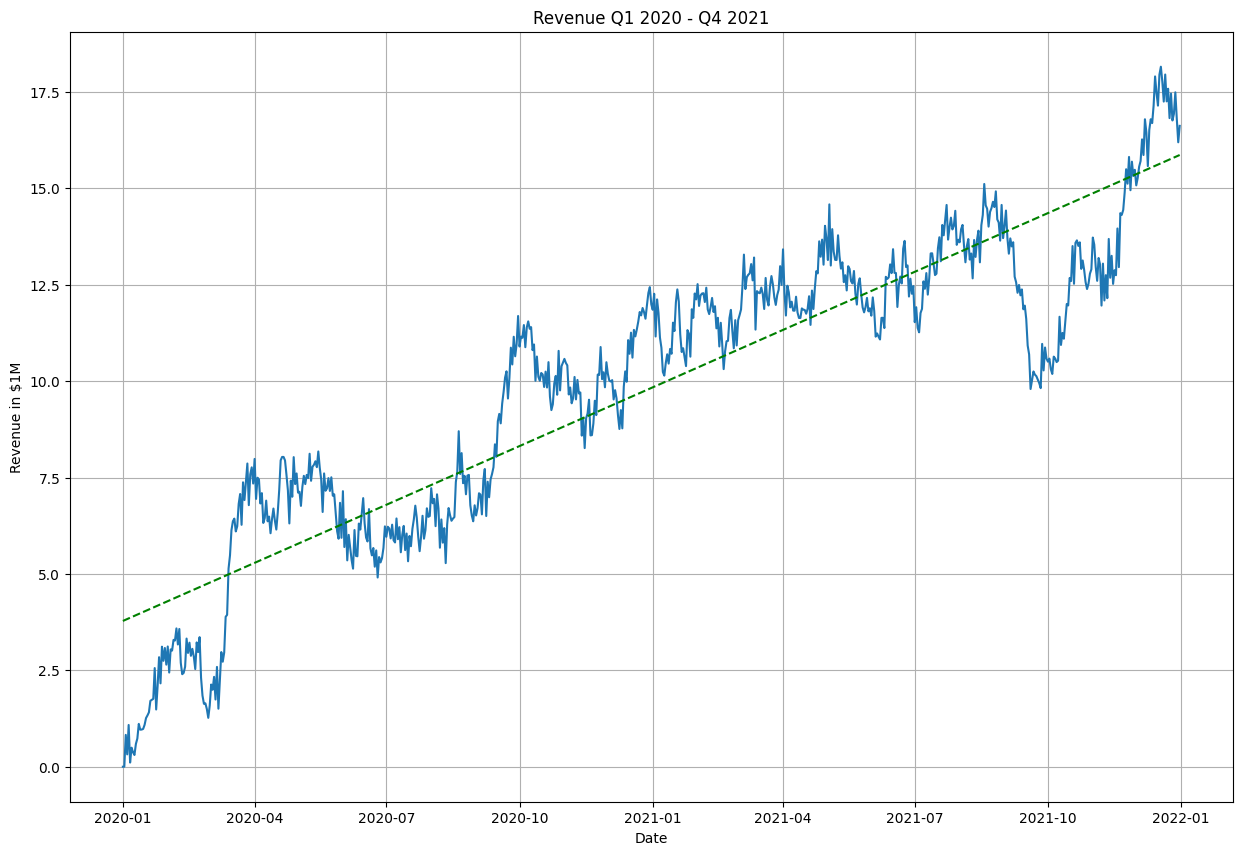

In [4]:
# let's take a look at our time series

plt.figure(figsize=(15,10))
plt.plot(time_df)
plt.title("Revenue Q1 2020 - Q4 2021")
plt.xlabel("Date")
plt.ylabel("Revenue in $1M")

# Trend line
x = mdates.date2num(time_df.index)
y = time_df["Revenue"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "g--")

plt.grid(True)
plt.show()

In [5]:
# export our clean data
time_df.to_csv("cleaned_time_data.csv")

C3: 
Using the Augmented Dickey-Fuller test, I found our initial data was not stationary. I fed the Revenue column through the function, and it returned a p-value of .321. Since that is greater than the .05 necessary to reject the null hypothesis, we have to say that this time series is not stationary. Because of that, I had to difference the data to make it stationary. The following code details the two different instances of running the Augmented Dickey-Fuller test as well as diff’ing the data.

In [6]:
# Checking for stationarity in our series

result = adfuller(time_df["Revenue"])
print("Test stats: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

Test stats:  -1.924612157310181
p-value:  0.3205728150793977
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [7]:
# p-value was > .05, we fail to reject the null hyp
# need to diff data, make it stationary

stationary_time_df = time_df.diff().dropna()

result = adfuller(stationary_time_df["Revenue"])
print("Test stats: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

Test stats:  -44.874527193876
p-value:  0.0
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [8]:
# split into testing and training

train = stationary_time_df.iloc[:-180]
test = stationary_time_df.iloc[-180:]

print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

train.to_csv("train_time_data.csv")
test.to_csv("test_time_data.csv")

Train shape:  (550, 1)
Test shape:  (180, 1)


C4: 
The cleaning steps done above were:
1. Checked for null values - would have dropped them if found.
2. Made "Day" column actual dates.
3. Set the index of the data frame to the new "Day" dates.
4. Differenced the data to ensure stationarity with the ADF test.
5. Split the data into training and testing data sets with a 75/25 split.

C5:
See attached "cleaned_time_data.csv," "train_time_data.csv," and "test_time_data.csv."

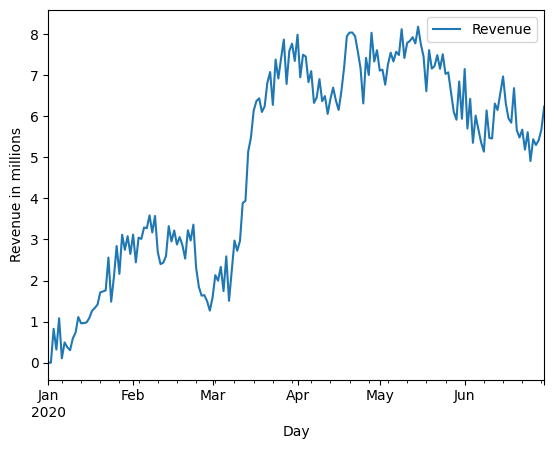

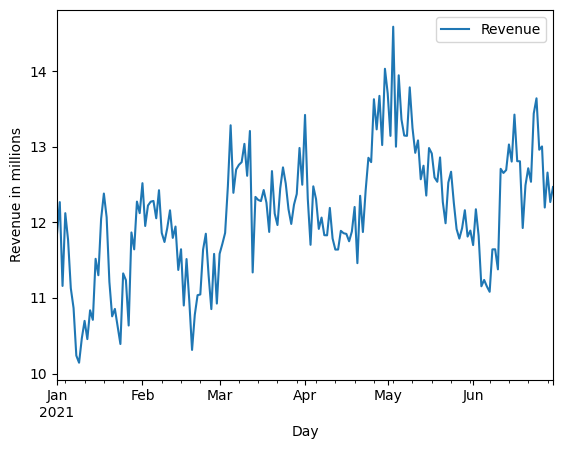

In [9]:
# Looking for and visualizing seasonality

time_df.loc[:"2020-6-30"].plot()
plt.ylabel("Revenue in millions")
plt.show()

time_df.loc["2021-1-1":"2021-6-30"].plot()
plt.ylabel("Revenue in millions")
plt.show()

D1: Seasonality

There is a slight seasonal trend in the data, but nothing conclusive. I plotted the first quarter of the data given above - the first half of 2020. Note that there is a massive spike in the month of March. When looking at the following year, this trend does not continue, March is a roller coaster of ups and downs with no clear spike. This raises the question of what could have caused the boom in March of 2020. I would argue that there is no seasonality represented here. While the spike does happen at a particular time in the year, it is not predictable as it is not replicated the following year.

Looking at the seasonal feature of the decomposed data below, there is some kind of repetitive consistency, but the peaks of the graph appear too close together to have any meaningful seasonality. It also shows the magnitude of the component to be .1, so while that may be a lot of money to an individual, .1 of the 1 million dollar scale is moderately less important to the company at large.

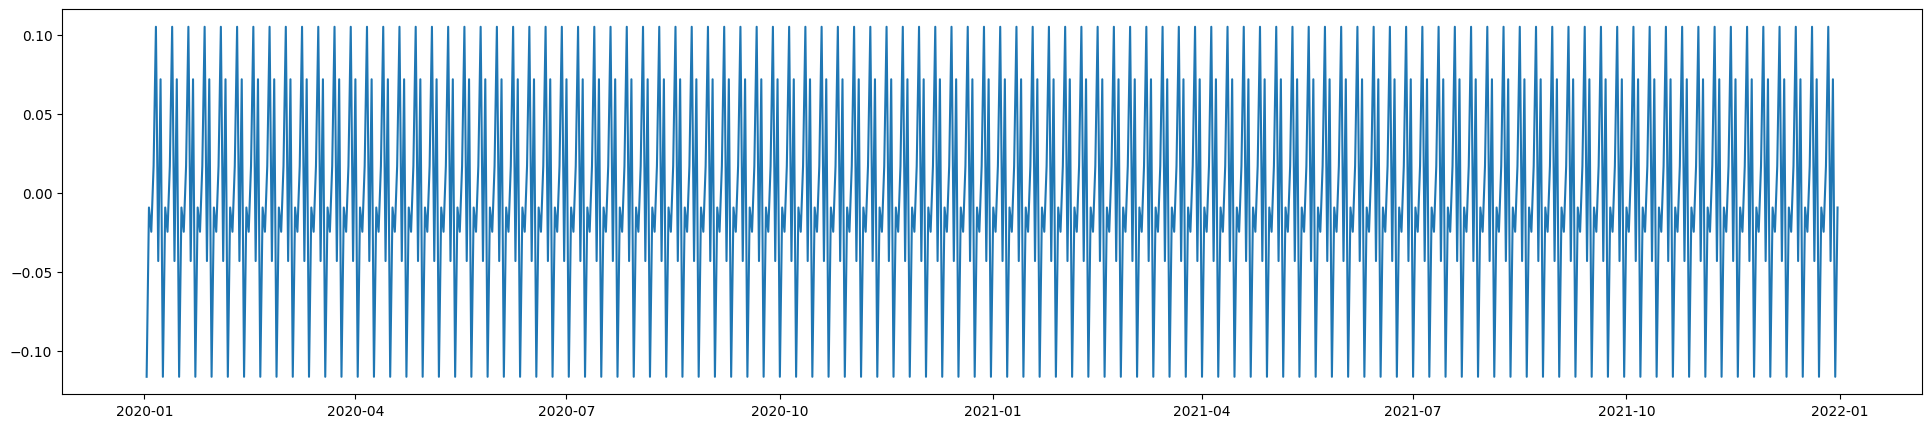

In [10]:
# decomposing and plotting seasonality

seasonal_decomp = seasonal_decompose(stationary_time_df)
plt.figure(figsize = [24, 5])
plt.plot(seasonal_decomp.seasonal)

D1: Trends

As represented in the trend line in C1, revenue is clearly trending in the positive direction. Over the two years in the data, overall revenue has substantially increased, and appears to still be climbing. I assume this will be the case, and this trend line will be a good sanity check for our predictions later on. The following trend graph from the decomposition shows that to be true - it is centered positively.

<Axes: xlabel='Day'>

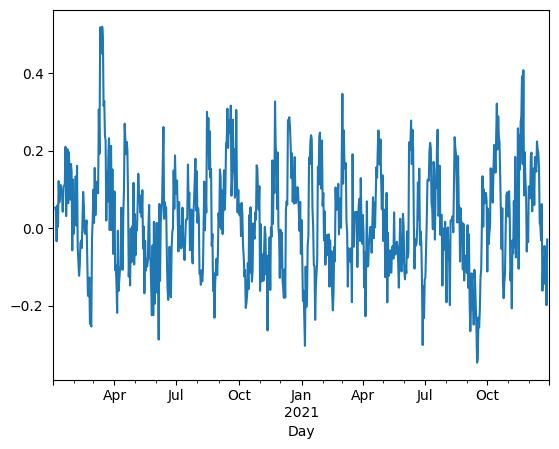

In [11]:
# trends

seasonal_decomp.trend.plot()

D1: Autocorrelation

With the following autocorrelation function, the lag one and lag two values are significant. This means we can confidently predict the next value using the previous two. Interestingly, the 22nd lag also appears to be significant, but is not useful for us because the previous twenty lags are too close to zero.

Looking at the partial autocorrelation in tandem with the autocorrelation shows us that we should be using an AR(1) model for predictions. 

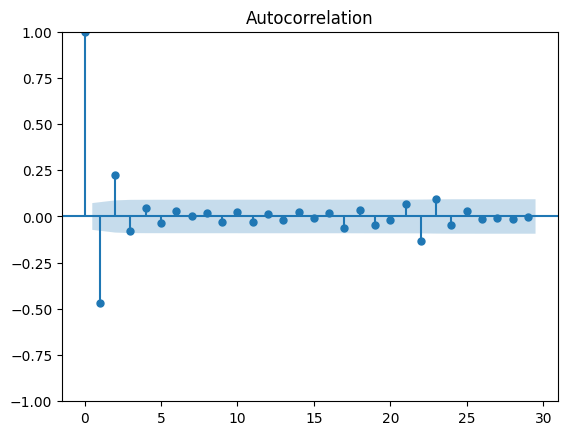

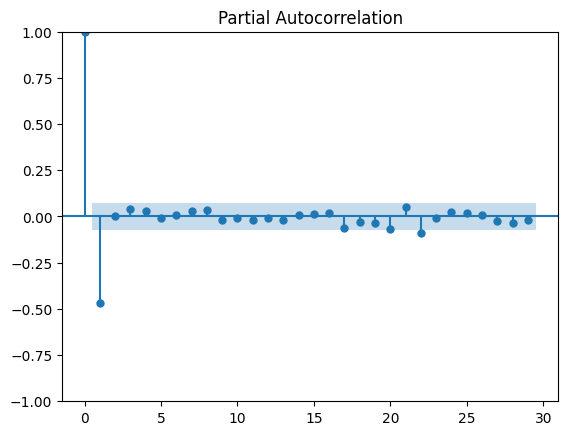

In [12]:
# autocorrecation function on diff'd data

plot_acf(stationary_time_df)
plt.show()

plot_pacf(stationary_time_df)
plt.show()

D1: Spectral Density

Nothing seems awry with the spectral density - the values appear scattered and not following a pattern. This is not unusual for spectral density.

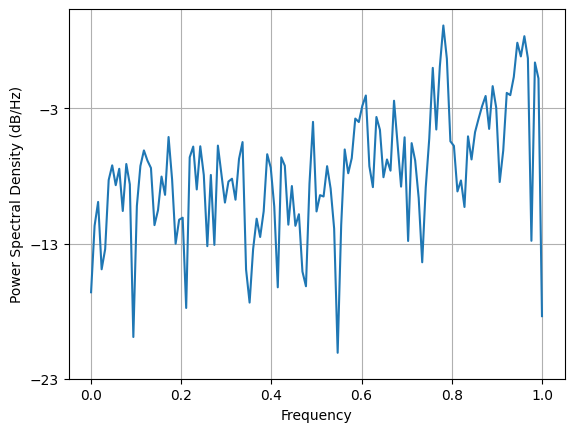

In [13]:
# spectral density

plt.psd(stationary_time_df.Revenue)
plt.show()

D1: Decomposed Time Series

The full decomposed time series can be seen below. This gives an overview of the graphs provided elsewhere in this presentation; good for seeing if there is anything noteworthy at a glance.

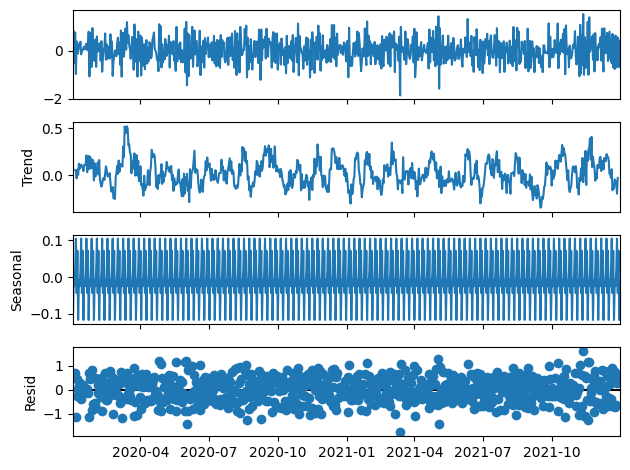

In [14]:
# decomposed data

seasonal_decomp.plot()
plt.show()

D1: Residuals

The residual graph contained within the decomposition does not appear to have any clear trends. It is a lot of noise centered around 0, which is in line with what we expect from a differenced, stationary time series. 

<Axes: title={'center': 'Residuals'}, xlabel='Day'>

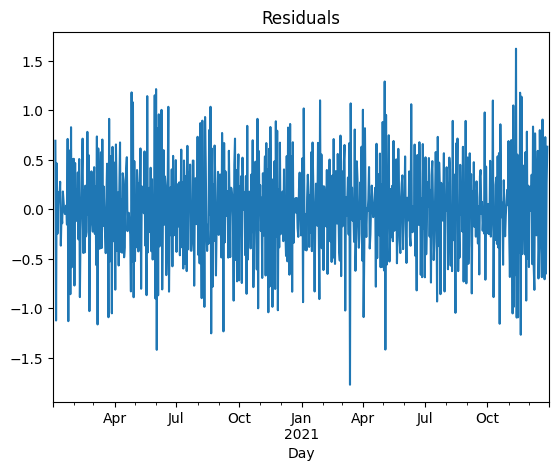

In [15]:
# residuals

plt.title("Residuals")
seasonal_decomp.resid.plot()

D2:

Based on the ACF and PACF graphs above, the ideal model is an AR(1) model. This gives us our p value: how many lag observations we are looking for. If we used our original data, d would be 1, but since we are using already differenced data, we do not need to make it stationary with our ARIMA model. Based on the ACF graph, our q value seems like it should be 1 as well.

A quick check using the auto_arima function below shows us that our lowest AIC (and therefore best) model uses order (1, 0, 0), with (2, 0, 0) and (1, 0, 1) close behind.

In [16]:
# auto ARIMA

stepwise_fit=auto_arima(train["Revenue"], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=736.854, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=866.751, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=733.431, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=761.171, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=865.571, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=735.391, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=735.399, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=736.785, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=733.700, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.436 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  550
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -363.715
Date:                Tue, 26 Nov 2024   AIC                            733.431
Time:                        06:35:30   BIC                            746.361
Sample:                    01-02-2020   HQIC                           738.484
                         - 07-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0302      0.020      1.500      0.134      -0.009       0.070
ar.L1         -0.4666      0.037    -12.556      0.000      -0.539      -0.394
sigma2         0.2196      0.014     15.710      0.000       0.192       0.247
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.94   Prob(JB):                         0.55
Heteroskedasticity (H):               1.01   Skew:                            -0.06
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

With the above results, we can conclude the equation of our ARIMA model is the following first-order autoregressive model:

X<sub>t</sub> = -0.4666(X<sub>(t-1)</sub>) + .0206

In [17]:
model = ARIMA(train["Revenue"], order=(1,0,0), freq="D")
model = model.fit()
model.summary()

C:\Users\jackg\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  550
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -363.715
Date:                Tue, 26 Nov 2024   AIC                            733.431
Time:                        06:35:35   BIC                            746.361
Sample:                    01-02-2020   HQIC                           738.484
                         - 07-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0206      0.014      1.505      0.132      -0.006       0.047
ar.L1         -0.4666      0.037    -12.556      0.000      -0.539      -0.394
sigma2         0.2196      0.014     15.710      0.000       0.192       0.247
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.94   Prob(JB):                         0.55
Heteroskedasticity (H):               1.01   Skew:                            -0.06
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

D3: 

Using my model, I created a forecast 90 days past testing data set: a total of 270 days, approximately three fiscal quarters.

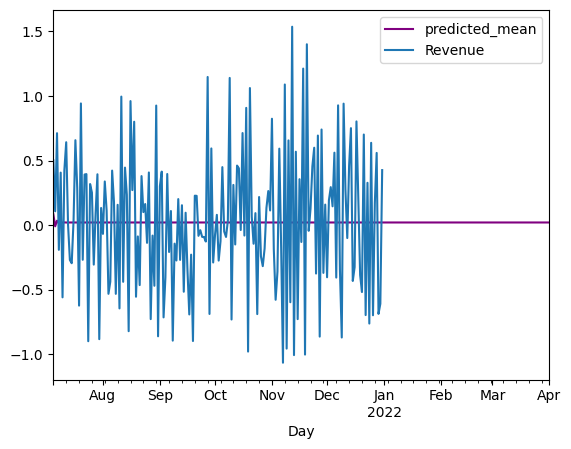

2021-07-05    0.084257
2021-07-06   -0.009145
2021-07-07    0.034433
2021-07-08    0.014101
2021-07-09    0.023588
                ...   
2022-03-28    0.020570
2022-03-29    0.020570
2022-03-30    0.020570
2022-03-31    0.020570
2022-04-01    0.020570
Freq: D, Name: predicted_mean, Length: 271, dtype: float64


In [32]:
# Prediction code adapted from Dr. Sewell's D213 Webinar

start = len(train)
end = len(train)+len(test)+90
pred = model.get_prediction(start=start, end=end)
pred_mean = pred.predicted_mean

pred_mean.plot(legend=True, color = "purple")
test["Revenue"].plot(legend=True)
plt.show()

print(pred_mean)

D3 cont:

With the near zero values provided by the above code, I found it seemed quite close to the mean of the differenced function, but it didn’t give me any clear insights. My research led me to find the GitHub portfolio of a previous student who ran into this same issue. They had found that this provided the daily change in value as opposed to the value itself. 

Using code from WJTownsend’s GitHub page where they documented this discovery, I was able to change those values into predictions that made sense!

In [33]:
# code from GitHub user WJTownsend

forecast_temp = pd.DataFrame(pred_mean)
# rename columns
forecast_temp.rename(columns={"predicted_mean" : "Revenue"}, inplace=True)
# train values and forecasted values
forecast_df = pd.concat([train.copy(), forecast_temp.copy()])

forecast_df = forecast_df.cumsum()

print(forecast_df)

              Revenue
2020-01-02   0.000793
2020-01-03   0.825542
2020-01-04   0.320332
2020-01-05   1.082554
2020-01-06   0.107654
...               ...
2022-03-28  16.801755
2022-03-29  16.822325
2022-03-30  16.842894
2022-03-31  16.863464
2022-04-01  16.884033

[821 rows x 1 columns]


D3 cont:

The same issue occurred with the confidence intervals, requiring transformation to be applicable to the non-differenced data.

In [34]:
confidence_intervals = pred.conf_int()
lower_limits = confidence_intervals.loc[:,"lower Revenue"]
upper_limits = confidence_intervals.loc[:,"upper Revenue"]

print(confidence_intervals)

            lower Revenue  upper Revenue
2021-07-05      -0.834306       1.002819
2021-07-06      -1.022768       1.004478
2021-07-07      -0.998725       1.067592
2021-07-08      -1.023261       1.051463
2021-07-09      -1.014688       1.061863
...                   ...            ...
2022-03-28      -1.017959       1.059098
2022-03-29      -1.017959       1.059098
2022-03-30      -1.017959       1.059098
2022-03-31      -1.017959       1.059098
2022-04-01      -1.017959       1.059098

[271 rows x 2 columns]


In [35]:
# Code adapted from GitHub user WJTownsend

# initalize a df with the initial value on 2021-07-05, as that is where the conf intervals start
conf_df_init = pd.DataFrame({"lower Revenue" : [11.350524], "upper Revenue" : [11.350524], "date" : ["2021-07-05"]})
# index
conf_df_init["date"] = pd.to_datetime(conf_df_init["date"])
conf_df_init.set_index("date", inplace=True)
print(conf_df_init)

            lower Revenue  upper Revenue
date                                    
2021-07-05      11.350524      11.350524


In [36]:
# Concat and cumsum, as with forecasted values
confidence_intervals = pd.concat([conf_df_init, confidence_intervals])

confidence_intervals = confidence_intervals.cumsum()

confidence_intervals = confidence_intervals.loc["2021-07-05" : "2022-03-31"]

print(confidence_intervals)

            lower Revenue  upper Revenue
2021-07-05      11.350524      11.350524
2021-07-05      10.516218      12.353343
2021-07-06       9.493450      13.357822
2021-07-07       8.494725      14.425414
2021-07-08       7.471463      15.476877
...                   ...            ...
2022-03-27    -259.231526     292.962410
2022-03-28    -260.249485     294.021509
2022-03-29    -261.267445     295.080607
2022-03-30    -262.285404     296.139705
2022-03-31    -263.303364     297.198804

[271 rows x 2 columns]


In [37]:
# reassign lower and upper limits

lower_limits = confidence_intervals.loc[:,"lower Revenue"]
upper_limits = confidence_intervals.loc[:,"upper Revenue"]

D3 cont:

Finally, it call came together to create our forecasted revenue graph!

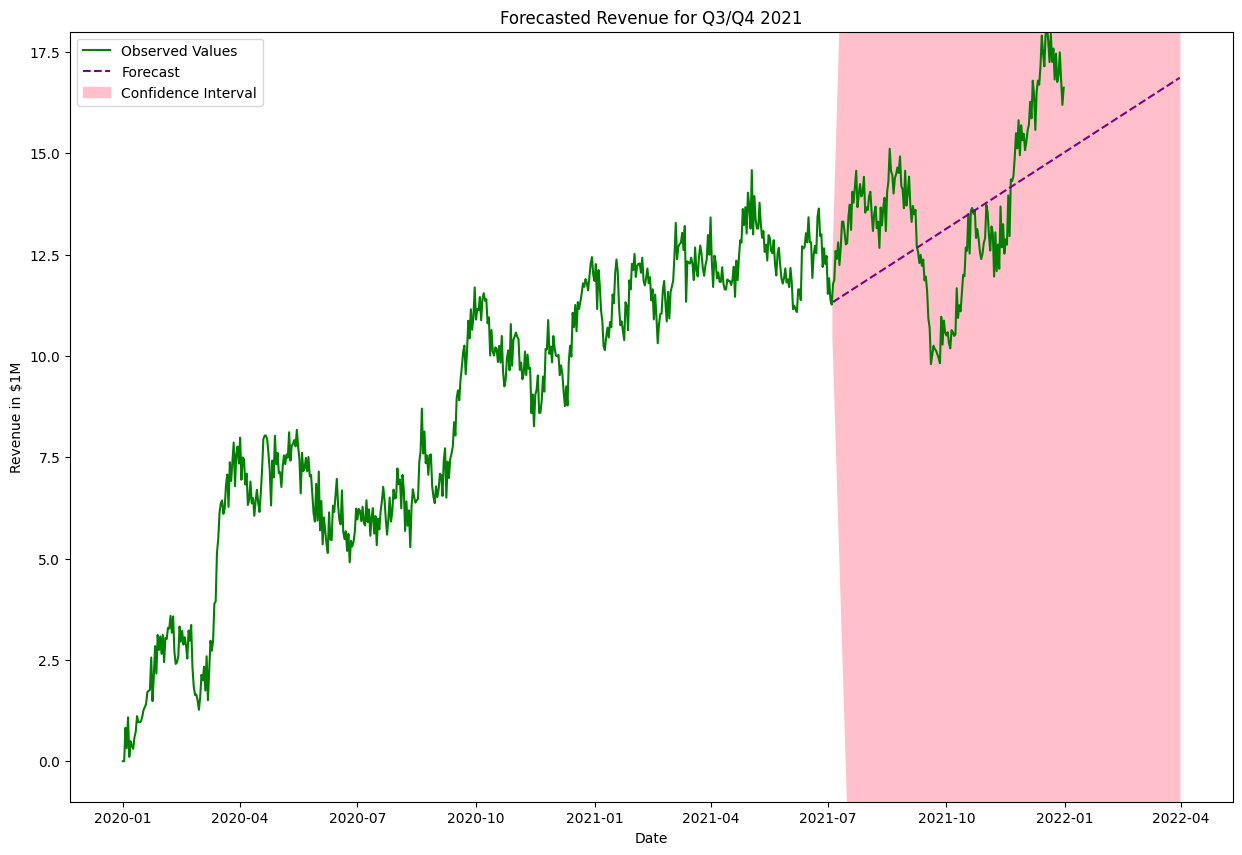

In [38]:
# plotting the forecasted data

plt.figure(figsize = [15,10])
plt.title("Forecasted Revenue for Q3/Q4 2021")
plt.xlabel("Date")
plt.ylabel("Revenue in $1M")

plt.plot(time_df, color = "green", label = "Observed Values")

plt.plot(forecast_df.loc["2021-07-05" : "2022-03-31"], color = "purple", linestyle = "dashed", label="Forecast")

plt.fill_between(confidence_intervals.index, lower_limits, upper_limits, color = "pink", label = "Confidence Interval")

plt.ylim(-1,18)

plt.legend()

plt.show()

D4: All calculations and output can be seen in above code.

D5: Code provided here and in separate .ipynb file.

E1: 

The ARIMA model I selected ended up effectively being of order (1, 1, 0) on the original time series. Based on the ACF and PACF functions, the first and third variables were determined. Using the Augmented Dickey-Fuller test, I found the time series to be stationary when differenced once, so our second variable was 1 (0 when I called the function, as I passed the already-differenced “train” dataframe into the ARIMA model). To confirm, I plugged the dataframe into the “autoarima” function, and it output (1, 0, 0) as the optimal order for our ARIMA model. Using the variables from the summary of the ARIMA model, we get the following equation:

X<sub>t</sub> = -0.4666(X<sub>(t-1)</sub>) + .0206


The confidence interval of this model is, in a word, abysmal. At the end of the forecast, the confidence interval is at ±250, which is basically unusable. This speaks to the volatility of the data itself, spanning from 1 million to almost 18 million over the course of the observed time. It is difficult for the model to confidently pin down the consistent, erratic growth of the company. The model did a very good job of predicting the test data - it just allowed itself a massive margin of error. The actual prediction of Q1 2022 was chosen due to it being in the immediate future where we could see the model verified in real time or rework it if the actual, observed values do not line up.

For the forecast length, I wanted to pick something “real world” applicable that highlighted that factor of the assessment. Because the time series is of revenue, fiscal quarters seemed like the best option. I decided my “test” data would be the last two fiscal quarters of the data, spanning from June 1st, 2021 to December 31st, 2021. This gave a large enough training sample as well - a 75/25 split of train to test. The forecast itself is the quarter directly following the test data from January 1st, 2022 through to the end of March. This gives a clear metric and timeframe by which the company can interpret results, and even add the actual data into the time series for forecasts of Q2 2022.

In [39]:
# RMSE calculations

rmse = mean_squared_error(time_df.loc["2021-07-05" : "2021-12-31"], forecast_df.loc["2021-07-05" : "2021-12-31"])
print("RMSE: ", rmse)

RMSE:  3.295637135678859


E1 cont:

For model evaluation, I used the plot_diagnostics method of the model as well as Root Mean Squared Error. RSME gave me approximately 3.3, which is firmly in the realm of "okay" for the model dealing with values up to approximately 18.

<Figure size 1600x1600 with 0 Axes>

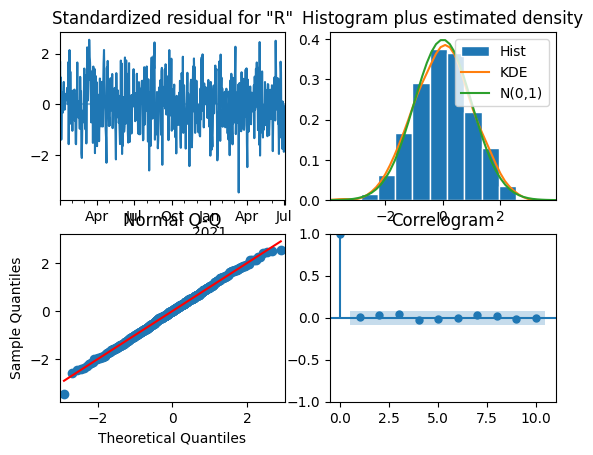

In [40]:
# model evaluation

plt.figure(figsize = [16,16])
model.plot_diagnostics()
plt.show()

E1 cont:

First in the top left. is the standardized residual graph. The fact that it has no pattern is a good sign for the quality of our model. Next, top right, is a histogram of the normal distribution and a line representing the kernel density estimation (KDE). The KDE line stays close to the normal distribution, which also bodes well for the model. The bottom left graph shows a normal Q-Q plot, where values on the red line follow an expected, normal distribution. Nearly all of ours do. Finally, the correlogram shows all lags past 0 are insignificant, which is ideal for our model. 

Overall, the numbers say we have a statistically sound model on our hands.

E2:

The model provides a linear representation that sticks quite close to the mean values of our test data, and can be seen again below.

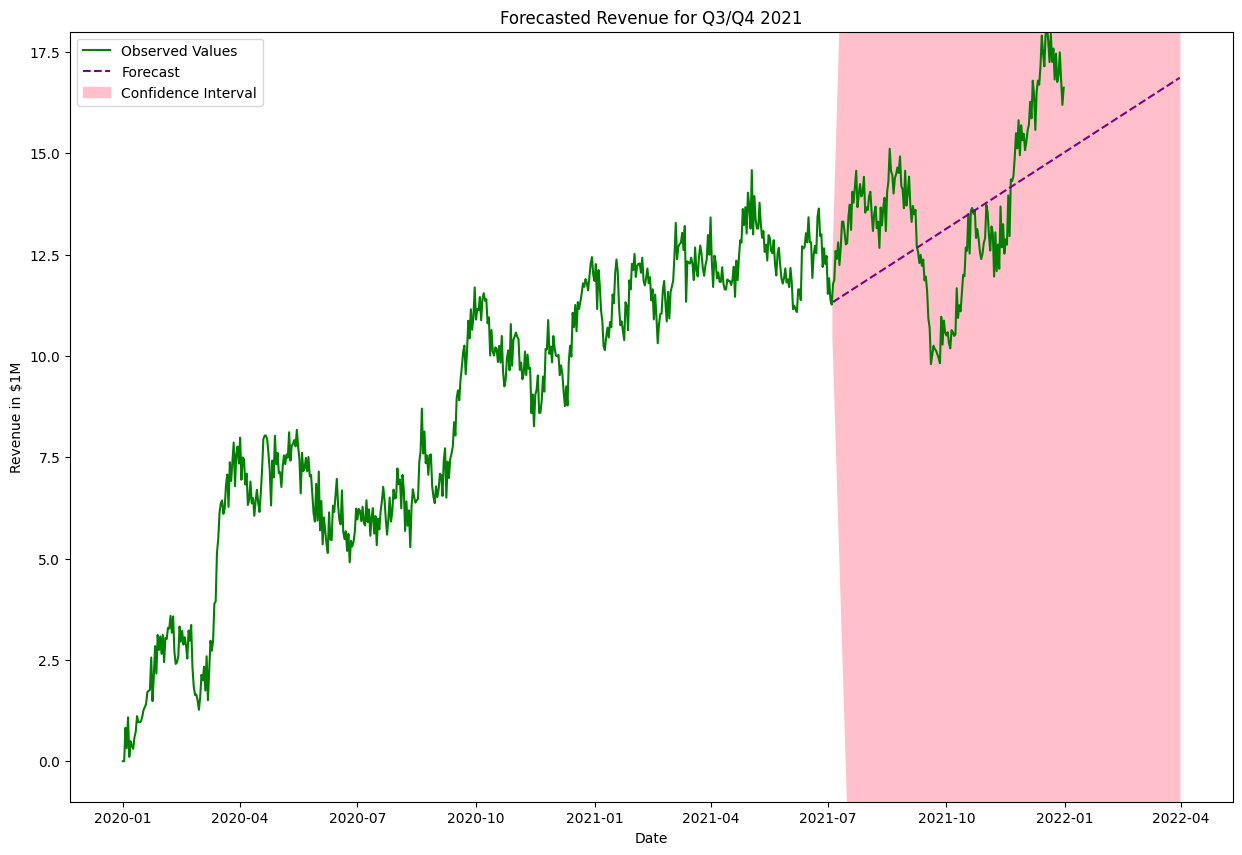

In [44]:
plt.figure(figsize = [15,10])
plt.title("Forecasted Revenue for Q3/Q4 2021")
plt.xlabel("Date")
plt.ylabel("Revenue in $1M")

plt.plot(time_df, color = "green", label = "Observed Values")

plt.plot(forecast_df.loc["2021-07-05" : "2022-03-31"], color = "purple", linestyle = "dashed", label="Forecast")

plt.fill_between(confidence_intervals.index, lower_limits, upper_limits, color = "pink", label = "Confidence Interval")

plt.ylim(-1,18)

plt.legend()

plt.show()

E3: 

As always, I would recommend further analysis. Knowledge is power, and we want to be sure to learn all we can with this data set, as revenue is one of the most vital metrics to a business. I am personally biased, though, as performing further analysis keeps me employed!

In the short term, I would recommend the company stay the course and keep doing what they’re doing. Profits have been growing, and clearly customer churn is kept to a minimum if revenue generated is on the rise. I would tell them to focus on what exactly happened in March of 2020 and September of 2021 to cause that large boom and bust, respectively. Knowing the business practices that led to these would help set the company up for another jump in revenue while safeguarding it against a decline like in September. 

Long term, it may be useful to break down data by revenue source (assuming this is the same telecommunications company we have seen data from in previous assessments). This company offers phone plans, internet services, streaming, and cybersecurity. If one of these branches isn’t pulling its weight or keeping customers from churning, it could be worth it to assess if that facet of the company is still relevant. 

F: This Notebook has been submitted as both a .ipynb file and a PDF.

G: Sources cited in code.